# Mohit Yadav
## yadav171@umn.edu
## CSCI 5541 HW1

In [1]:
## Importing packages.
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import re
import string
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sentencepiece as spm

import torchtext
torchtext.disable_torchtext_deprecation_warning()

In [2]:
## Set device to Cuda if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
## Download IMDB data.
from torchtext.datasets import IMDB

train_iter, test_iter = IMDB(split=('train', 'test'))

/Users/saturn/miniforge3/envs/nlp/lib/python3.12/site-packages/torchdata/datapipes/__init__.py:18: UserWarning: 
################################################################################
WARNING!
The 'datapipes', 'dataloader2' modules are deprecated and will be removed in a
future torchdata release! Please see https://github.com/pytorch/data/issues/1196
to learn more and leave feedback.
################################################################################

  deprecation_warning()


We see a lot of html in the text, and there are symbols which don't have meaning for our work. So we will need to clean the data before using.

In [4]:
## Convert the data to a pandas df for easy processing.
train_df = pd.DataFrame(train_iter, columns=['label', 'text'])
test_df = pd.DataFrame(test_iter, columns=['label', 'text'])

Visualize the data.

In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   25000 non-null  int64 
 1   text    25000 non-null  object
dtypes: int64(1), object(1)
memory usage: 390.8+ KB


In [6]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   25000 non-null  int64 
 1   text    25000 non-null  object
dtypes: int64(1), object(1)
memory usage: 390.8+ KB


In [7]:
## See the text stored in the dataframe.
print(train_df['text'][0])

I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ever tried to enter this country, therefore being a fan of films considered "controversial" I really had to see this for myself.<br /><br />The plot is centered around a young Swedish drama student named Lena who wants to learn everything she can about life. In particular she wants to focus her attentions to making some sort of documentary on what the average Swede thought about certain political issues such as the Vietnam War and race issues in the United States. In between asking politicians and ordinary denizens of Stockholm about their opinions on politics, she has sex with her drama teacher, classmates, and married men.<br /><br />What kills me about I AM CURIOUS-YELLOW is that 40 years ago, this was considered pornographic. Really, the sex and nudity scenes are few and far between, eve

There are a lot of symbols and html text in the sample that needs to be removed.

In [8]:
#Special thanks to https://www.kaggle.com/tanulsingh077 for this function
def clean_text(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

<>:6: SyntaxWarning: invalid escape sequence '\['
<>:7: SyntaxWarning: invalid escape sequence '\S'
<>:11: SyntaxWarning: invalid escape sequence '\w'
<>:6: SyntaxWarning: invalid escape sequence '\['
<>:7: SyntaxWarning: invalid escape sequence '\S'
<>:11: SyntaxWarning: invalid escape sequence '\w'
/var/folders/1l/q74c92gx3gzf6b0b5lsr2n0m0000gn/T/ipykernel_32052/256755324.py:6: SyntaxWarning: invalid escape sequence '\['
  text = re.sub('\[.*?\]', '', text)
/var/folders/1l/q74c92gx3gzf6b0b5lsr2n0m0000gn/T/ipykernel_32052/256755324.py:7: SyntaxWarning: invalid escape sequence '\S'
  text = re.sub('https?://\S+|www\.\S+', '', text)
/var/folders/1l/q74c92gx3gzf6b0b5lsr2n0m0000gn/T/ipykernel_32052/256755324.py:11: SyntaxWarning: invalid escape sequence '\w'
  text = re.sub('\w*\d\w*', '', text)


In [9]:
## Clean the text and store in a txt file for training the tokenizer.
with open("cleaned_text.txt", "w") as f:
    for label, text in train_iter:
        f.write(clean_text(text).strip() + "\n")

In [10]:
### BPE Tokenization.
## Create spm model with our data and vocab size of 8000.
VOCAB_SIZE = 8000
spm.SentencePieceTrainer.train(input='./cleaned_text.txt', model_prefix='bpe_model', vocab_size=VOCAB_SIZE, model_type='bpe')

sp = spm.SentencePieceProcessor(model_file='bpe_model.model')

## Tokenization functions.
def tokenize_into_str(text):
    return " ".join(sp.encode(text, out_type=str))

def tokenize_into_idx(text):
    return " ".join([str(tok) for tok in sp.encode(text)])

sentencepiece_trainer.cc(78) LOG(INFO) Starts training with : 
trainer_spec {
  input: ./cleaned_text.txt
  input_format: 
  model_prefix: bpe_model
  model_type: BPE
  vocab_size: 8000
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  pretokenization_delimiter: 
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  required_chars: 
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  train_extremely_large_corpus: 0
  seed_sentencepieces_file: 
  hard_vocab_limit: 1
  use_all_vocab: 0
  unk_id: 0
  bos_id: 1
  eos_id: 2
  pad_id: -1
  unk_piece: <unk>
  bos_piece: <s>
  eos_piece: </s>
  pad_piece: <pad>
  unk_surface:  ⁇ 
  enable_differential_privacy: 0
  di

In [11]:
## Add cleaned text to dataframes.
train_df['cleaned_text'] = train_df['text'].apply(clean_text)
train_df['tokenized_text'] = train_df['cleaned_text'].apply(tokenize_into_str)
train_df['tokenized_idx'] = train_df['cleaned_text'].apply(tokenize_into_idx)

test_df['cleaned_text'] = test_df['text'].apply(clean_text)
test_df['tokenized_text'] = test_df['cleaned_text'].apply(tokenize_into_str)
test_df['tokenized_idx'] = test_df['cleaned_text'].apply(tokenize_into_idx)

Added: freq=605 size=2340 all=100472 active=6031 piece=▁total
bpe_model_trainer.cc(268) LOG(INFO) Added: freq=598 size=2360 all=100818 active=6377 piece=▁cheesy
bpe_model_trainer.cc(268) LOG(INFO) Added: freq=590 size=2380 all=101354 active=6913 piece=▁unique
bpe_model_trainer.cc(268) LOG(INFO) Added: freq=585 size=2400 all=101802 active=7361 piece=▁thank
bpe_model_trainer.cc(159) LOG(INFO) Updating active symbols. max_freq=585 min_freq=121
bpe_model_trainer.cc(268) LOG(INFO) Added: freq=578 size=2420 all=102191 active=5472 piece=uc
bpe_model_trainer.cc(268) LOG(INFO) Added: freq=571 size=2440 all=102840 active=6121 piece=ises
bpe_model_trainer.cc(268) LOG(INFO) Added: freq=565 size=2460 all=103328 active=6609 piece=▁popular
bpe_model_trainer.cc(268) LOG(INFO) Added: freq=559 size=2480 all=103925 active=7206 piece=▁leading
bpe_model_trainer.cc(268) LOG(INFO) Added: freq=553 size=2500 all=104332 active=7613 piece=lu
bpe_model_trainer.cc(159) LOG(INFO) Updating active symbols. max_freq=5

piece=▁unw
bpe_model_trainer.cc(268) LOG(INFO) Added: freq=176 size=5260 all=144616 active=7699 piece=▁carol
bpe_model_trainer.cc(268) LOG(INFO) Added: freq=175 size=5280 all=144865 active=7948 piece=▁jail
bpe_model_trainer.cc(268) LOG(INFO) Added: freq=174 size=5300 all=145162 active=8245 piece=▁prime
bpe_model_trainer.cc(159) LOG(INFO) Updating active symbols. max_freq=174 min_freq=49
bpe_model_trainer.cc(268) LOG(INFO) Added: freq=173 size=5320 all=145328 active=7423 piece=▁toler
bpe_model_trainer.cc(268) LOG(INFO) Added: freq=172 size=5340 all=145537 active=7632 piece=▁breaking
bpe_model_trainer.cc(268) LOG(INFO) Added: freq=171 size=5360 all=145678 active=7773 piece=▁intellectual
bpe_model_trainer.cc(268) LOG(INFO) Added: freq=169 size=5380 all=145808 active=7903 piece=▁exh
bpe_model_trainer.cc(268) LOG(INFO) Added: freq=169 size=5400 all=145937 active=8032 piece=▁scares
bpe_model_trainer.cc(159) LOG(INFO) Updating active symbols. max_freq=169 min_freq=48
bpe_model_trainer.cc(268)

In [12]:
## Clean the dataframe for idx and nan values.
train_df.replace({"tokenized_idx": ""}, np.nan, inplace=True)
train_df.dropna(subset=['tokenized_idx'], inplace=True)

test_df.replace({"tokenized_idx": ""}, np.nan, inplace=True)
test_df.dropna(subset=['tokenized_idx'], inplace=True)

In [13]:
## Add the size of tokens to df, will be used by model.
def count_tokens(text):
    return len(text.split())

train_df['num_tokens'] = train_df['tokenized_idx'].apply(count_tokens)
test_df['num_tokens'] = test_df['tokenized_idx'].apply(count_tokens)

In [14]:
## See sample of data.
train_df.head()

,label,text,cleaned_text,tokenized_text,tokenized_idx,num_tokens
0,1,I rented I AM CURIOUS-YELLOW from my video sto...,i rented i am curiousyellow from my video stor...,▁i ▁rented ▁i ▁am ▁curious ye llow ▁from ▁my ▁...,6 3518 6 260 4297 4458 789 177 222 1251 2756 3...,318
1,1,"""I Am Curious: Yellow"" is a risible and preten...",i am curious yellow is a risible and pretentio...,▁i ▁am ▁curious ▁yellow ▁is ▁a ▁ris ible ▁and ...,6 260 4297 7446 42 4 3926 661 30 4104 720 4879...,268
2,1,If only to avoid making this type of film in t...,if only to avoid making this type of film in t...,▁if ▁only ▁to ▁avoid ▁making ▁this ▁type ▁of ▁...,214 266 32 2031 853 62 1671 33 89 40 7 1928 62...,102
3,1,This film was probably inspired by Godard's Ma...,this film was probably inspired by godards mas...,▁this ▁film ▁was ▁probably ▁inspired ▁by ▁god ...,62 89 78 815 3746 163 1271 1459 14 2034 128 11...,138
4,1,"Oh, brother...after hearing about this ridicul...",oh brotherafter hearing about this ridiculous ...,▁oh ▁brother after ▁hearing ▁about ▁this ▁ridi...,1388 1693 4148 4685 198 62 1663 89 85 6916 219...,387


In [15]:
test_df.head()

,label,text,cleaned_text,tokenized_text,tokenized_idx,num_tokens
0,1,I love sci-fi and am willing to put up with a ...,i love scifi and am willing to put up with a l...,▁i ▁love ▁scifi ▁and ▁am ▁willing ▁to ▁put ▁up...,6 418 2507 30 260 3706 32 758 240 94 4 536 250...,270
1,1,"Worth the entertainment value of a rental, esp...",worth the entertainment value of a rental espe...,▁worth ▁the ▁entertainment ▁value ▁of ▁a ▁rent...,783 7 1956 2720 33 4 4923 894 214 95 172 723 3...,237
2,1,its a totally average film with a few semi-alr...,its a totally average film with a few semialri...,▁its ▁a ▁totally ▁average ▁film ▁with ▁a ▁few ...,151 4 1452 2226 89 94 4 608 3739 599 1350 723 ...,142
3,1,STAR RATING: ***** Saturday Night **** Friday ...,star rating saturday night friday night fri...,▁star ▁rating ▁saturday ▁night ▁friday ▁night ...,787 1707 4819 813 5125 813 5125 4236 5471 813 ...,423
4,1,"First off let me say, If you haven't enjoyed a...",first off let me say if you havent enjoyed a v...,▁first ▁off ▁let ▁me ▁say ▁if ▁you ▁havent ▁en...,352 374 767 190 445 214 95 2020 1467 4 2043 17...,142


In [16]:
## Stats of number of tokens in data.
print(f"Train:\t mean={train_df['num_tokens'].mean():.2f}, std={train_df['num_tokens'].std():.2f}, max={train_df['num_tokens'].max():.2f}, min={train_df['num_tokens'].min():.2f}")
print(f"Test:\t mean={test_df['num_tokens'].mean():.2f}, std={test_df['num_tokens'].std():.2f}, max={test_df['num_tokens'].max():.2f}, min={test_df['num_tokens'].min():.2f}")

Train:	 mean=268.81, std=207.25, max=3265.00, min=10.00
Test:	 mean=263.51, std=202.07, max=2699.00, min=6.00


There is a lot of variation in token size as seen from the high std values.

In [17]:
## Remove non relevant data from the dfs for training.
train_df = train_df[['tokenized_idx', 'num_tokens', 'label']]
test_df = test_df[['tokenized_idx', 'num_tokens', 'label']]

In [18]:
## Make the labels 0 and 1.
train_df.loc[:,'label'] = train_df['label'] - 1
test_df.loc[:,'label'] = test_df['label'] - 1

In [19]:
## Check to see appropriate conversion.
print("Unique Labels in train data: ",train_df['label'].unique())
print("Unique Labels in test data: ",test_df['label'].unique())

Unique Labels in train data:  [0 1]
Unique Labels in test data:  [0 1]


In [20]:
train_df.head()

,tokenized_idx,num_tokens,label
0,6 3518 6 260 4297 4458 789 177 222 1251 2756 3...,318,0
1,6 260 4297 7446 42 4 3926 661 30 4104 720 4879...,268,0
2,214 266 32 2031 853 62 1671 33 89 40 7 1928 62...,102,0
3,62 89 78 815 3746 163 1271 1459 14 2034 128 11...,138,0
4,1388 1693 4148 4685 198 62 1663 89 85 6916 219...,387,0


In [21]:
test_df.head()

,tokenized_idx,num_tokens,label
0,6 418 2507 30 260 3706 32 758 240 94 4 536 250...,270,0
1,783 7 1956 2720 33 4 4923 894 214 95 172 723 3...,237,0
2,151 4 1452 2226 89 94 4 608 3739 599 1350 723 ...,142,0
3,787 1707 4819 813 5125 813 5125 4236 5471 813 ...,423,0
4,352 374 767 190 445 214 95 2020 1467 4 2043 17...,142,0


In [22]:
## Create the DataLoader Class,
## I am not reading from disk as all the data was already loaded into RAM.
class imdbDataset(Dataset):
    def __init__(self, data):
        self.dataset = data

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        text_indices = [int(token_idx) for token_idx in self.dataset.iloc[idx]['tokenized_idx'].split()]
        number_of_tokens = self.dataset.iloc[idx]['num_tokens']
        label = self.dataset.iloc[idx]['label']
        return text_indices, number_of_tokens, label

In [23]:
## Define hyperparameters
BATCH_SIZE = 32
EMBED_DIM = 32
NUM_CLASS = 2

## Set Seed
torch.manual_seed(33)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [24]:
### Creating a Single layer model.
class SLMLP(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_class):
        super().__init__()
        self.embedding_sum = nn.EmbeddingBag(vocab_size, embed_dim, sparse=True)
        self.fc = nn.Linear(embed_dim, num_class)
        self.init_weights()
    
    def init_weights(self):
        initrange = 0.5
        self.embedding_sum.weight.data.uniform_(-initrange, initrange)
        self.fc.weight.data.uniform_(-initrange, initrange)
        self.fc.bias.data.zero_()
    
    def forward(self, text, offsets):
        return self.fc(self.embedding_sum(text, offsets))

In [25]:
## Create the multi layer model.
class MLP(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_size, num_class):
        super().__init__()
        self.embedding_sum = nn.EmbeddingBag(vocab_size, embed_dim, sparse=True)
        self.fc1 = nn.Linear(embed_dim, hidden_size)
        self.fc2 = nn.Linear(hidden_size, num_class)
        self.relu = nn.ReLU()
        self.init_weights()

    def init_weights(self):
        initrange = 0.5
        self.embedding_sum.weight.data.uniform_(-initrange, initrange)
        self.fc1.weight.data.uniform_(-initrange, initrange)
        self.fc2.weight.data.uniform_(-initrange, initrange)
        self.fc1.bias.data.zero_()
        self.fc2.bias.data.zero_()

    def forward(self, text, offsets):
        x = self.embedding_sum(text, offsets)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

In [26]:
## Create function to generate data in a batch.
def generate_batch(batch):
    batch_indices = []
    batch_labels = []
    offsets = [0]

    for text_indices, number_of_tokens, label in batch:
        batch_indices.extend(text_indices)
        batch_labels.append(label)
        offsets.append(number_of_tokens)

    batch_indices = torch.tensor(batch_indices, dtype=torch.long)
    batch_labels = torch.tensor(batch_labels, dtype=torch.long)
    offsets = torch.tensor(offsets[:-1]).cumsum(dim=0)
    return batch_indices, batch_labels, offsets

In [27]:
## Define DataLoaders.
train_loader = DataLoader(imdbDataset(train_df), batch_size=BATCH_SIZE, shuffle=True, collate_fn=generate_batch)
test_loader = DataLoader(imdbDataset(test_df), batch_size=BATCH_SIZE, shuffle=True, collate_fn=generate_batch)

## Single Layer MLP.

In [29]:
## Define model and training parameters.
modelSLMLP = SLMLP(VOCAB_SIZE, EMBED_DIM, NUM_CLASS)

## Define Training parameters
criterionSLMLP = nn.CrossEntropyLoss()
optimizerSLMLP = torch.optim.SGD(modelSLMLP.parameters(), lr=1.0)
schedulerSLMLP = torch.optim.lr_scheduler.StepLR(optimizerSLMLP, 1, gamma=0.9)

### Train the Single layer model.

In [30]:
### Training Loop for single layer model.
N_EPOCHS = 31

lossSLMLP = []
accuracySLMLP = []
test_accuracySLMLP = []

for epoch in range(N_EPOCHS):
    train_loss, train_acc = train_func(train_loader, modelSLMLP, criterionSLMLP, optimizerSLMLP, schedulerSLMLP)
    test_loss, test_acc = val_func(test_loader, modelSLMLP, criterionSLMLP)

    print(f'Epoch {epoch + 1} \tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}% | Test. Acc: {test_acc*100:.2f}%')

    lossSLMLP.append(train_loss)
    accuracySLMLP.append(train_acc)
    test_accuracySLMLP.append(test_acc)

print(f"\nFinished Training, final accuracy on test data is : {test_accuracySLMLP[-1]*100:.2f}%")

Epoch 1 	Train Loss: 0.021 | Train Acc: 58.45% | Test. Acc: 61.92%
Epoch 2 	Train Loss: 0.017 | Train Acc: 74.21% | Test. Acc: 71.36%
Epoch 3 	Train Loss: 0.014 | Train Acc: 80.28% | Test. Acc: 80.70%
Epoch 4 	Train Loss: 0.013 | Train Acc: 82.78% | Test. Acc: 83.35%
Epoch 5 	Train Loss: 0.012 | Train Acc: 84.50% | Test. Acc: 84.19%
Epoch 6 	Train Loss: 0.011 | Train Acc: 85.84% | Test. Acc: 85.14%
Epoch 7 	Train Loss: 0.010 | Train Acc: 86.78% | Test. Acc: 82.12%
Epoch 8 	Train Loss: 0.010 | Train Acc: 87.28% | Test. Acc: 85.69%
Epoch 9 	Train Loss: 0.009 | Train Acc: 87.88% | Test. Acc: 86.31%
Epoch 10 	Train Loss: 0.009 | Train Acc: 88.36% | Test. Acc: 84.57%
Epoch 11 	Train Loss: 0.009 | Train Acc: 88.74% | Test. Acc: 86.30%
Epoch 12 	Train Loss: 0.009 | Train Acc: 88.93% | Test. Acc: 86.70%
Epoch 13 	Train Loss: 0.009 | Train Acc: 89.24% | Test. Acc: 86.65%
Epoch 14 	Train Loss: 0.008 | Train Acc: 89.50% | Test. Acc: 86.78%
Epoch 15 	Train Loss: 0.008 | Train Acc: 89.63% | Test. A

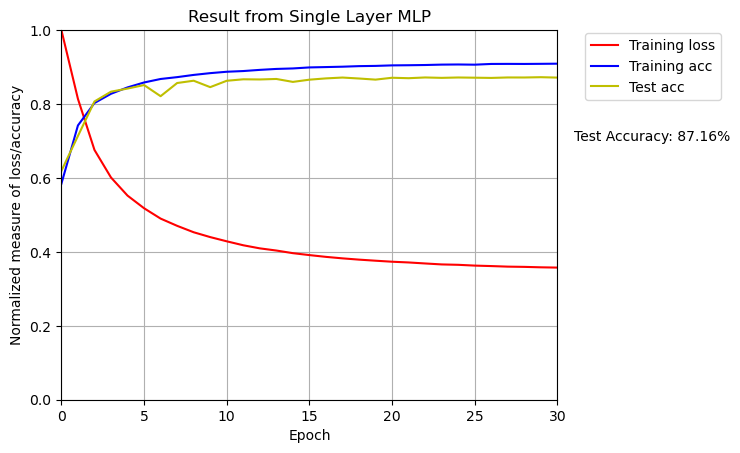

In [31]:
## Plot the loss and accuracy
plt.xlabel("Epoch")
plt.ylabel("Normalized measure of loss/accuracy")
x_len = list(range(len(accuracySLMLP)))

plt.axis([0,max(x_len),0,1])
plt.title("Result from Single Layer MLP")
lossSLMLP = np.asarray(lossSLMLP)/max(lossSLMLP)
plt.plot(x_len, lossSLMLP, 'r', label='Training loss')
plt.plot(x_len, accuracySLMLP, 'b', label='Training acc')
plt.plot(x_len, test_accuracySLMLP, 'y', label='Test acc')
plt.grid(True)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.2)
plt.text(31, 0.7, f"Test Accuracy: {test_accuracySLMLP[-1]*100:.2f}%")
plt.show()


# Multi-Layer Perceptron with intermediate layer of size 100.

In [32]:
HIDDEN_SIZE = 100
modelMLP = MLP(VOCAB_SIZE, EMBED_DIM, HIDDEN_SIZE, NUM_CLASS).to(device)

## Define Training parameters
criterionMLP = nn.CrossEntropyLoss()
optimizerMLP = torch.optim.SGD(modelMLP.parameters(), lr=1.0)
schedulerMLP = torch.optim.lr_scheduler.StepLR(optimizerMLP, 1, gamma=0.9)

In [33]:
### Training Loop for MLP with 100 dim. of intermedialte layer.

lossMLP = []
accuracyMLP = []
test_accuracyMLP = []

for epoch in range(N_EPOCHS):
    train_loss, train_acc = train_func(train_loader, modelMLP, criterionMLP, optimizerMLP, schedulerMLP)
    test_loss, test_acc = val_func(test_loader, modelMLP, criterionMLP)

    print(f'Epoch {epoch + 1} \tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}% | Test. Acc: {test_acc*100:.2f}%')

    lossMLP.append(train_loss)
    accuracyMLP.append(train_acc)
    test_accuracyMLP.append(test_acc)
print(f"\nFinished Training, final accuracy on test data is : {test_accuracyMLP[-1]*100:.2f}%")

Epoch 1 	Train Loss: 0.021 | Train Acc: 59.52% | Test. Acc: 65.50%
Epoch 2 	Train Loss: 0.017 | Train Acc: 73.53% | Test. Acc: 77.44%
Epoch 3 	Train Loss: 0.014 | Train Acc: 80.08% | Test. Acc: 80.08%
Epoch 4 	Train Loss: 0.012 | Train Acc: 83.06% | Test. Acc: 68.93%
Epoch 5 	Train Loss: 0.011 | Train Acc: 85.00% | Test. Acc: 84.30%
Epoch 6 	Train Loss: 0.010 | Train Acc: 86.66% | Test. Acc: 81.73%
Epoch 7 	Train Loss: 0.010 | Train Acc: 86.89% | Test. Acc: 80.24%
Epoch 8 	Train Loss: 0.009 | Train Acc: 88.00% | Test. Acc: 76.12%
Epoch 9 	Train Loss: 0.009 | Train Acc: 88.84% | Test. Acc: 86.74%
Epoch 10 	Train Loss: 0.008 | Train Acc: 89.33% | Test. Acc: 80.46%
Epoch 11 	Train Loss: 0.008 | Train Acc: 89.95% | Test. Acc: 86.48%
Epoch 12 	Train Loss: 0.008 | Train Acc: 90.48% | Test. Acc: 87.20%
Epoch 13 	Train Loss: 0.007 | Train Acc: 90.66% | Test. Acc: 70.52%
Epoch 14 	Train Loss: 0.007 | Train Acc: 91.07% | Test. Acc: 84.21%
Epoch 15 	Train Loss: 0.007 | Train Acc: 91.28% | Test. A

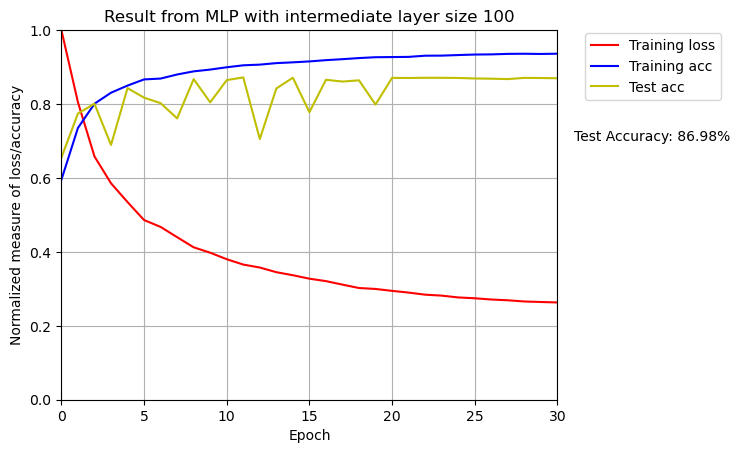

In [34]:
## Plot the loss and accuracy
plt.xlabel("Epoch")
plt.ylabel("Normalized measure of loss/accuracy")
x_len = list(range(len(accuracyMLP)))

plt.axis([0,max(x_len),0,1])
plt.title("Result from MLP with intermediate layer size 100")
lossMLP = np.asarray(lossMLP)/max(lossMLP)
plt.plot(x_len, lossMLP, 'r', label='Training loss')
plt.plot(x_len, accuracyMLP, 'b', label='Training acc')
plt.plot(x_len, test_accuracyMLP, 'y', label='Test acc')
plt.grid(True)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.2)
plt.text(31, 0.7, f"Test Accuracy: {test_accuracyMLP[-1]*100:.2f}%")
plt.show()


## Comparision between two-layer MLP to a single layer MLP.

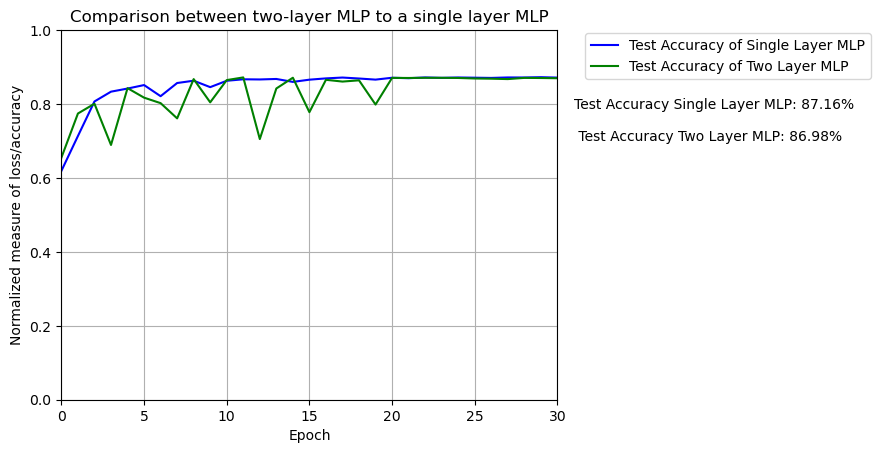

In [35]:
## Comparision between two-layer MLP to a single layer MLP.

plt.xlabel("Epoch")
plt.ylabel("Normalized measure of loss/accuracy")
x_len = list(range(len(accuracyMLP)))

plt.axis([0,max(x_len),0,1])
plt.title("Comparison between two-layer MLP to a single layer MLP")
plt.plot(x_len, test_accuracySLMLP, 'b', label='Test Accuracy of Single Layer MLP')
plt.plot(x_len, test_accuracyMLP, 'g', label='Test Accuracy of Two Layer MLP')
plt.grid(True)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.2)
plt.text(31, 0.7, f"Test Accuracy Single Layer MLP: {test_accuracySLMLP[-1]*100:.2f}%\n\n Test Accuracy Two Layer MLP: {test_accuracyMLP[-1]*100:.2f}%")
plt.show()


From the plot, we can see that the test accuracy for the two-layer MLP is slightly lower than that for the single-layer MLP, possibly due to overfitting on the test data. We observe that with the two-layer MLP, the training loss decreases more than it does for the single-layer MLP, but this improvement doesn't carry over to the validation and test data, indicating a problem of overfitting. Since the multi-layer model has significantly more parameters, it attempts to overfit the training data to minimize the training loss as much as possible.

# Multi-Layer Perceptron with intermediate layer of size 200.

In [36]:
HIDDEN_SIZE2 = 200
modelMLP2 = MLP(VOCAB_SIZE, EMBED_DIM, HIDDEN_SIZE2, NUM_CLASS).to(device)

## Define Training parameters
criterionMLP2 = nn.CrossEntropyLoss()
optimizerMLP2 = torch.optim.SGD(modelMLP2.parameters(), lr=1.0)
schedulerMLP2 = torch.optim.lr_scheduler.StepLR(optimizerMLP2, 1, gamma=0.9)

In [37]:
### Training Loop for MLP with intermediate layer size 200.

lossMLP2 = []
accuracyMLP2 = []
test_accuracyMLP2 = []

for epoch in range(N_EPOCHS):
    train_loss, train_acc = train_func(train_loader, modelMLP2, criterionMLP2, optimizerMLP2, schedulerMLP2)
    test_loss, test_acc = val_func(test_loader, modelMLP2, criterionMLP2)

    print(f'Epoch {epoch + 1} \tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}% | Test. Acc: {test_acc*100:.2f}%')

    lossMLP2.append(train_loss)
    accuracyMLP2.append(train_acc)
    test_accuracyMLP2.append(test_acc)
print(f"\nFinished Training, final accuracy on test data is : {test_accuracyMLP2[-1]*100:.2f}%")

Epoch 1 	Train Loss: 0.021 | Train Acc: 60.02% | Test. Acc: 71.53%
Epoch 2 	Train Loss: 0.016 | Train Acc: 74.89% | Test. Acc: 74.67%


KeyboardInterrupt: 

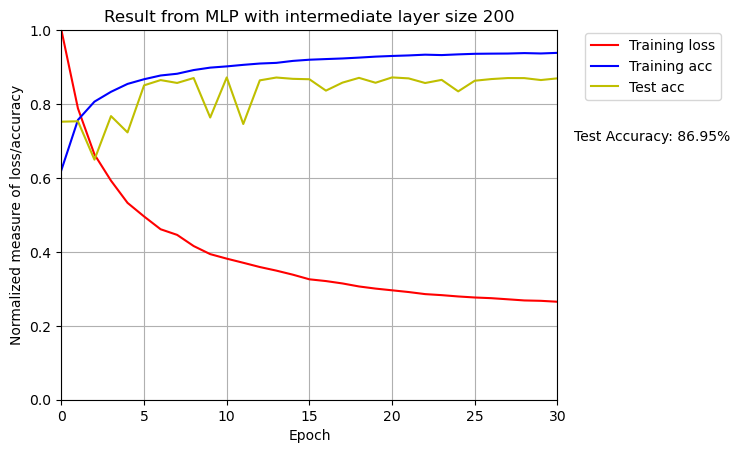

In [47]:
## Plot the loss and accuracy
plt.xlabel("Epoch")
plt.ylabel("Normalized measure of loss/accuracy")
x_len = list(range(len(accuracyMLP2)))

plt.axis([0,max(x_len),0,1])
plt.title("Result from MLP with intermediate layer size 200")
lossMLP2 = np.asarray(lossMLP2)/max(lossMLP2)
plt.plot(x_len, lossMLP2, 'r', label='Training loss')
plt.plot(x_len, accuracyMLP2, 'b', label='Training acc')
plt.plot(x_len, test_accuracyMLP2, 'y', label='Test acc')
plt.grid(True)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.2)
plt.text(31, 0.7, f"Test Accuracy: {test_accuracyMLP2[-1]*100:.2f}%")
plt.show()


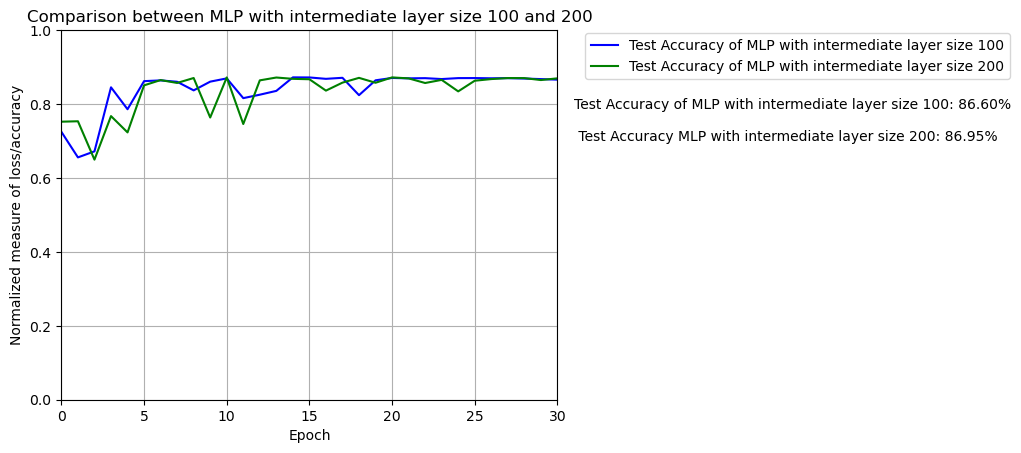

In [43]:
## Comparision between MLP with intermediate layer size 100 and 200.

plt.xlabel("Epoch")
plt.ylabel("Normalized measure of loss/accuracy")
x_len = list(range(len(accuracyMLP2)))

plt.axis([0,max(x_len),0,1])
plt.title("Comparison between MLP with intermediate layer size 100 and 200")
plt.plot(x_len, test_accuracyMLP, 'b', label='Test Accuracy of MLP with intermediate layer size 100')
plt.plot(x_len, test_accuracyMLP2, 'g', label='Test Accuracy of MLP with intermediate layer size 200')
plt.grid(True)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.2)
plt.text(31, 0.7, f"Test Accuracy of MLP with intermediate layer size 100: {test_accuracyMLP[-1]*100:.2f}%\n\n Test Accuracy MLP with intermediate layer size 200: {test_accuracyMLP2[-1]*100:.2f}%")
plt.show()

We observe a similar trend as in the comparison between the single-layer MLP and the dual-layer MLP. The MLP with an intermediate layer size of 200 fluctuated more than the one with a size of 100, possibly due to overfitting. Since the model with a 200-sized intermediate layer has greater flexibility to fit the training set, it attempts to reduce training errors excessively, leading to overfitting. That being said, there is no significant difference in the final test accuracies between the models with intermediate sizes of 100 and 200.

## Description of the task, dataset, and hardware used.

The task in this assingment was to classify the review of movies into positive or negetive using a Bag of Words approach with Multi layer perceptrons.
We used IMDB dataset from torchtext library.
For training the model I used my personal M1 macbook air without any GPU. As the models were light I was able to train them on my local machanice in less that 10 mins each.

## Test Accuracies

The models achieved following test accuracies on the dataset after training.
Single layer MLP:
Double Layer MPL with intermediate layer of size 100: 
Double Layer MPL with intermediate layer of size 200: 

## Hyperparameters

I have declared all the hyperparameters as global variables, they are listed below too with values.

BATCH_SIZE = 32            ## Tuned to make the model run fast on my local machine.

EMBED_DIM = 32             ## Kept same as in the tutorial

VOCAB_SIZE = 8000          ## Kept same as in the tutorial

HIDDEN_SIZE = 100 or 200   ## as given in problem statement.

N_EPOCHS = 26              ## Manually tuned, as I observed that training was almost stagnent after 25 epochs.

Learning Rate, lr=1.0      ## Kept same as in the tutorial

Scheduler Gamma, gamma = 0.9    ## Kept same as in the tutorial

## Error Analysis on the test set samples.

In [44]:
## make a function to get 5 incorrect predictions.
def get_two_incorrect_predictions(data, model):
    incorrect_predictions = []
    for i, (text_indices, label, number_of_tokens) in enumerate(data):
        predictions = model(text_indices, number_of_tokens)
        for i, prediction in enumerate(predictions):
            if prediction.argmax() != label[i]:
                if i == len(predictions) - 1:
                    incorrect_predictions.append((text_indices[number_of_tokens[i]:], label[i], prediction.argmax()))
                else:
                    incorrect_predictions.append((text_indices[number_of_tokens[i]:number_of_tokens[i+1]], label[i], prediction.argmax()))
                if len(incorrect_predictions) == 5:
                    return incorrect_predictions
    return incorrect_predictions


In [45]:
## Get two incorrect predictions for all the three models.

incorrect_predictionsSLMLP = get_two_incorrect_predictions(test_loader, modelSLMLP)
incorrect_predictionsMLP = get_two_incorrect_predictions(test_loader, modelMLP)
incorrect_predictionsMLP2 = get_two_incorrect_predictions(test_loader, modelMLP2)

incorrect_predictions = incorrect_predictionsSLMLP + incorrect_predictionsMLP + incorrect_predictionsMLP2

In [46]:
## Convert the incorrect predictions to text and print them out.
print(" '0' means negative and '1' means positive.")
for text_indice, actual_label, predicted_label in incorrect_predictions:
    decoded_text = sp.decode(text_indice.tolist())
    print("Actual Label: {} | Predicted Label: {} | Text: {}".format(actual_label, predicted_label, decoded_text))

 '0' means negative and '1' means positive.
Actual Label: 0 | Predicted Label: 1 | Text: this is a family movie set in rural america about a boy whose uncle presses sheep killing charges against his dog drum starting not only a family legal feud but community discord as their town begins to take sidesthis is formula film that attempts to be very touching and sweet its biggest weakness is that the only people who could really act were scott bakula defense lawyer ron perlman fatherdrums owner and the dog john shuck and kathy garver sissy from the original family affair as the uncle and his wife were okay the children were not that good basically they looked like they were acting and thats a problem when the film really revolves around them aaron fors who plays the bully donny makes me think of what the actor russell crowe must have looked liked as a child only with no talent but a lot of ham favorite line spoken by the prosecutor after scott bakulas defense closing trial speech well be l

### Analysis of samples with wrong predictions.

The samples with incorrect predictions seem a bit unclear to me as well. For instance, in one sample, the user spends a long time discussing all the good aspects of the movie at the beginning, only pointing out the negative parts at the very end. This might explain why the model predicted it as a positive review.

Some labels seem ambiguous, as users might write mostly good things about the movie, but the label is still negative, as seen in some samples.

A common observation is that many reviews with incorrect predictions describe the movie in great detail rather than focusing on the actual user opinion, which could be the source of the error. A movie’s storyline might include various negative words, but the movie could still be good, or vice-versa.